# Image Classification

The purpose of this project is to design and implement an image classification workflow, including data manipulation, visualization, and exploratory data analysis. The dataset is a compilation of image data of natural scenes around the world, and it is posted in Kaggle as Intel Image Classification if anyone is interested.

The data contains around 25K images of size 150x150 distributed under 6 categories. The train, test and prediction data is separated in each zip files, and there are around 14K images in the train, 3K in the test, and 7K in the prediction set.

We will build a neural network with TensorFlow to classify the images with more accuracy, and will describe the network and assess its performance.

***
## Loading the Data

In this section, we will read in the provided learning and test set images by using TensorFlow, to generate batches of tensor image data with real-time data augmentation (as explained in the documentation)

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

We will use **ImageDataGenerator** and **flow_from_directory** from TensorFlow to load the images in the training & test datasets, and encode the corresponding categories as below:
- buildings: 0
- forest: 1
- glacier: 2
- mountain: 3
- sea: 4
- street: 5

In [2]:
train_dir = r"C:\Users\Sang\Desktop\Projects\Image Classification\seg_train"

img_size = (150, 150) # Resizes the image since some images could be in different sizes
batch_size = 30 # Larger batches can lead to faster training time

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # Scales the pixel values of the image to [0,1]
    horizontal_flip=True,
    validation_split=0.2) # Uses 20% of training data for validation

train_data = train_data_gen.flow_from_directory(
    train_dir, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical', # Categorical since multiple classes (i.e. not binary)
    shuffle=True, # Shuffles the data by default
    subset='training')

Found 11230 images belonging to 6 classes.


We verified that the training dataset is correctly loaded. Let's quickly check the training labels, and similarly, we will create a validation dataset and load the test dataset.

In [3]:
train_indices = train_data.class_indices
print(train_indices) # Checks the encoding

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [4]:
validation = train_data_gen.flow_from_directory(
    train_dir, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True,
    subset='validation') # Validation set from the training set 

Found 2804 images belonging to 6 classes.


In [5]:
test_dir = r"C:\Users\Sang\Desktop\Projects\Image Classification\seg_test"

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True) 

test_data = test_data_gen.flow_from_directory(
    test_dir, 
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=False)

Found 3000 images belonging to 6 classes.


In [6]:
test_indices = test_data.class_indices
print(test_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


***
## Exploring the Dataset

With the loaded datasets, we can plot the distribution of images across different categories to see if the dataset is balanced or skewed, and identify categories that may need additional data augmentation or sampling. Moreover, we will visualize some sample images to get a better understanding of what the images look like and what kind of variations and similarities exist within and across different categories.

<function matplotlib.pyplot.show(close=None, block=None)>

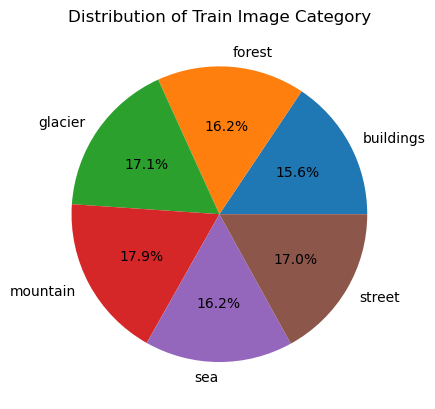

In [7]:
train_labels = train_data.labels
train_category = {}

category_counts = np.bincount(train_labels)
for category_name, category_index in train_indices.items():
    train_category[category_name] = category_counts[category_index]
    
values, labels = list(train_category.values()), list(train_category.keys())

plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Distribution of Train Image Category")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

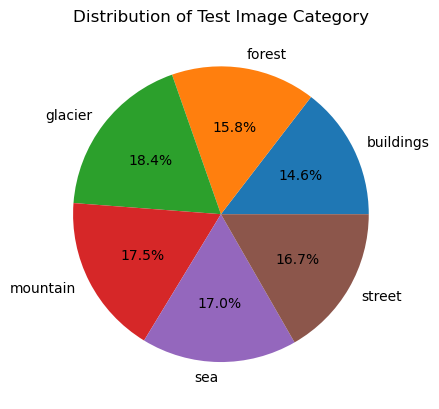

In [8]:
test_labels = test_data.labels
test_category = {}

category_counts = np.bincount(test_labels)
for category_name, category_index in test_indices.items():
    test_category[category_name] = category_counts[category_index]
    
values, labels = list(test_category.values()), list(test_category.keys())

plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Distribution of Test Image Category")
plt.show

From the two pie charts, we can observe that the distribution of image category is balanced, and consequently, we do not have any skewness towards a specific category. Let's visualize some sample images from our training dataset.

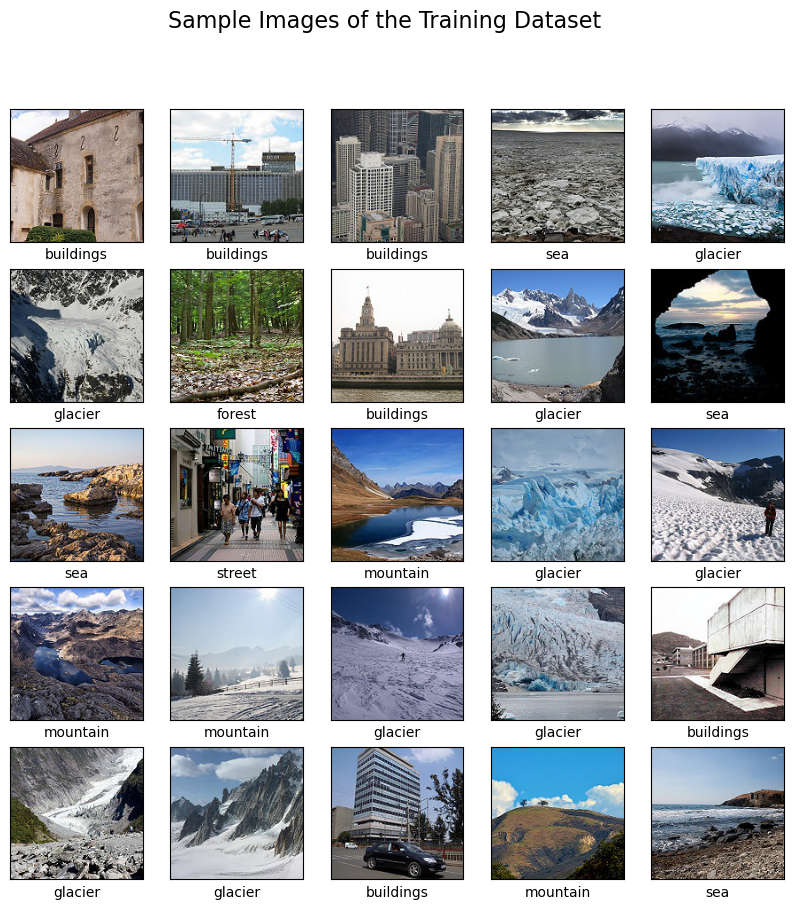

In [9]:
train_images, train_labels = next(train_data) # Contains the input images & corresponding labels
index_key = list(train_indices.keys()) # Converts categories in the dictionary into a list

fig = plt.figure(figsize=(10,10))
fig.suptitle("Sample Images of the Training Dataset", fontsize=16)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i]) # Shows the image in the dataset
    plt.xlabel(index_key[np.argmax(train_labels[i])]) # labels the image with the corresponding category

plt.show()

***
## Convolutional Neural Network

We confirmed that our data is fairly distributed among the categories, and we already preprocessed the dataset (such as scaling). Now, we can create the CNN model to predict the class labels.

Our model will be composed of different layers, namely:

- Conv2D: Used for processing 2D inputs, such as images, and feature extractions
- MaxPooling2D: Reduces the dimensionality of the input.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of (150, 150, 3) pixel values.
- Dense: Takes a flatten tensor of features as input and compute the output by applying a set of weights

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

After we build in the layers, we will compile the model with the following parameters:
- Optimizer: Uses Adam for adaptive learning annd faster convergence.
- Loss: Uses categorical_crossentropy since the labels are one-hot encoded even though we have 6 categories.
- Metrics: Measures the accuracy of the model on the training and validation data.

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

Let's fit our model with the training dataset, and we will also use the validation dataset to observe any overfit.

In [12]:
history = model.fit(train_data, epochs=12, validation_data=validation)

Epoch 1/12
375/375 [==============================] - 86s 220ms/step - loss: 1.0820 - accuracy: 0.5613 - val_loss: 0.8366 - val_accuracy: 0.6665
Epoch 2/12
375/375 [==============================] - 15s 39ms/step - loss: 0.7581 - accuracy: 0.7122 - val_loss: 0.6325 - val_accuracy: 0.7753
Epoch 3/12
375/375 [==============================] - 15s 39ms/step - loss: 0.6185 - accuracy: 0.7767 - val_loss: 0.5453 - val_accuracy: 0.7974
Epoch 4/12
375/375 [==============================] - 15s 39ms/step - loss: 0.5284 - accuracy: 0.8088 - val_loss: 0.5347 - val_accuracy: 0.8071
Epoch 5/12
375/375 [==============================] - 15s 39ms/step - loss: 0.4733 - accuracy: 0.8298 - val_loss: 0.5060 - val_accuracy: 0.8235
Epoch 6/12
375/375 [==============================] - 15s 39ms/step - loss: 0.4259 - accuracy: 0.8466 - val_loss: 0.4507 - val_accuracy: 0.8434
Epoch 7/12
375/375 [==============================] - 15s 39ms/step - loss: 0.3830 - accuracy: 0.8622 - val_loss: 0.4329 - val_accuracy

Let's plot the training and validation loss and accuracy.

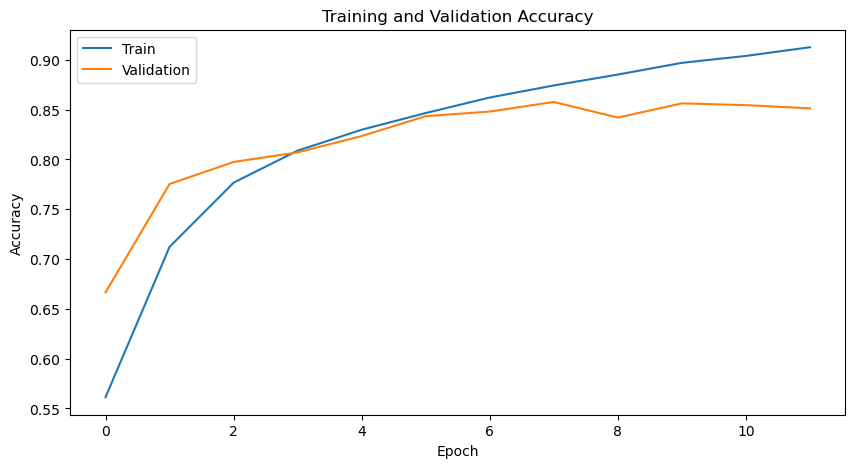

In [13]:
fig = plt.figure(figsize=(10,5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

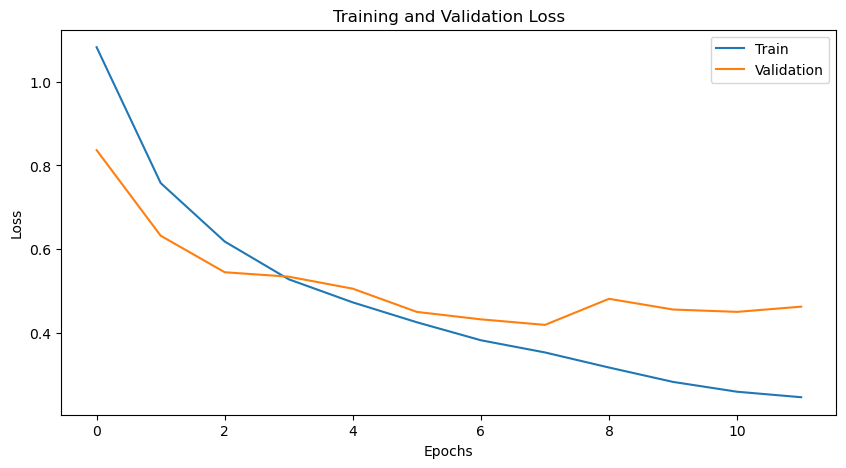

In [14]:
fig = plt.figure(figsize=(10,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Finally, we will evaluate the model performance on the test set by examining the accuracy.

In [15]:
test_loss = model.evaluate(test_data)

100/100 [==============================] - 2s 22ms/step - loss: 0.4585 - accuracy: 0.8580


***
## Error Analysis
Our model does relatively well given that the other two CNNs from Kaggle achieve about 76% and 83% accuracy. Let's try to understand the images that are misclassified by analyzing the confusion matrix.

In [16]:
y_pred = model.predict(test_data, steps=len(test_data), verbose=1) # Returns the model prediction on test set
y_pred = np.argmax(y_pred, axis=1) # Gets the predicted classes from the predicted probabilities
y_true = test_data.classes # Returns the true classes from the test set

100/100 [==============================] - 2s 20ms/step


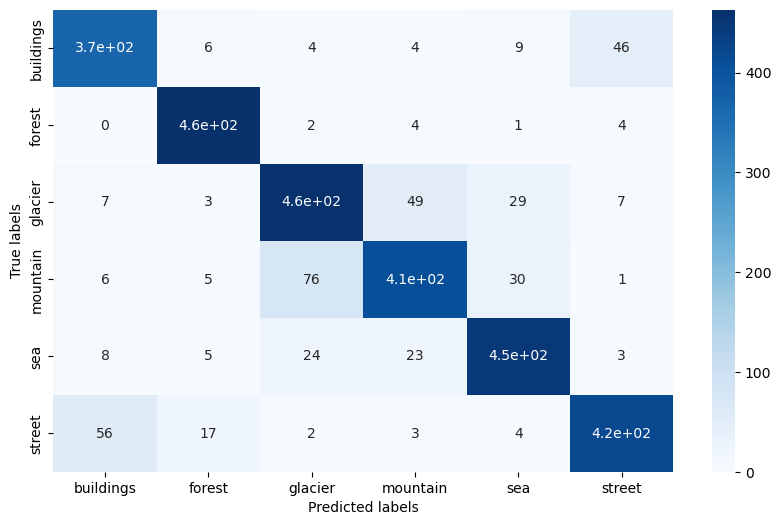

In [17]:
cm = confusion_matrix(y_true, y_pred)

labels = test_data.class_indices
labels = dict((v,k) for k,v in labels.items())

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

We can observe that the model is mainly having trouble with classifying glacier vs. mountain and building vs. streets. Intuitively, this makes sense because buildings could have streets in the images, and then, the shape of the mountain could look like a glacier.

***
## Pre-trained Networks
In this section, we will compare our CNN with two different pre-trained networks, namely ResNet50 and VGG16. These models have been used as the starting point for many other computer vision tasks, including object detection and image segmentation. Hopefully, we can leverage the weights of the pre-trained layers for improvement.

Consider the following parameters for the pre-trained models:
- **weights**: loads pre-trained on ImageNet
- **include_top**: False to allow adding input and output layers custom to our problem
- **input_shape**: corresponds to our image size, which has exactly 3 inputs channels, and width and height is no smaller than 32
- **pooling**: global average pooling will be applied to the output of the last convolutional block, which will be a 2D tensor
- **classes**: number of distinct categories or labels that the model is trained to recognize, which is 6 for our case

***
### ResNet
ResNet model has residual connections, which allow information to be passed across the layers without going through the entire layer. Generally, ResNet is composed of several blocks, with each block consisting of several convolutional layers followed by a batch normalization layer and a non-linear activation function. The output of the block is then added to the input of the block, which forms the residual connection.

In [18]:
resnet_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3),
    pooling='avg',
    classes=6)

In [19]:
model2 = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [20]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 23,850,758
Trainable params: 23,797,638
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
history2 = model2.fit(train_data, epochs=3, validation_data=validation)

Epoch 1/3
375/375 [==============================] - 107s 269ms/step - loss: 0.5610 - accuracy: 0.8139 - val_loss: 1.8922 - val_accuracy: 0.1619
Epoch 2/3
375/375 [==============================] - 98s 261ms/step - loss: 0.3694 - accuracy: 0.8741 - val_loss: 1.3030 - val_accuracy: 0.5567
Epoch 3/3
375/375 [==============================] - 98s 261ms/step - loss: 0.3215 - accuracy: 0.8889 - val_loss: 0.5889 - val_accuracy: 0.7921


In [22]:
test_loss2 = model2.evaluate(test_data)

100/100 [==============================] - 7s 71ms/step - loss: 0.6247 - accuracy: 0.7810


Looks like our CNN has better accuracy than the ResNet, which is expected given the small training dataset.

***
### VGG 16
Similarly, we will take a look at VGG16 model that was also trained on the ImageNet dataset, which contains over a million images belonging to 1000 different classes, where the images were preprocessed by subtracting the mean RGB value of the training set from each pixel.

In [23]:
vgg_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3),
    pooling='avg',
    classes=6)

In [24]:
model3 = tf.keras.Sequential([
    vgg_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [25]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 14,781,126
Trainable params: 14,781,126
Non-trainable params: 0
_________________________________________________________________


In [26]:
history3 = model3.fit(train_data, epochs=10, validation_data=validation)

Epoch 1/10
375/375 [==============================] - 129s 327ms/step - loss: 1.2626 - accuracy: 0.4903 - val_loss: 0.8751 - val_accuracy: 0.6676
Epoch 2/10
375/375 [==============================] - 119s 318ms/step - loss: 0.8372 - accuracy: 0.6764 - val_loss: 0.6382 - val_accuracy: 0.7732
Epoch 3/10
375/375 [==============================] - 119s 317ms/step - loss: 0.6960 - accuracy: 0.7469 - val_loss: 0.5598 - val_accuracy: 0.8014
Epoch 4/10
375/375 [==============================] - 119s 317ms/step - loss: 0.5985 - accuracy: 0.7830 - val_loss: 0.5521 - val_accuracy: 0.7935
Epoch 5/10
375/375 [==============================] - 119s 317ms/step - loss: 0.5159 - accuracy: 0.8156 - val_loss: 0.4589 - val_accuracy: 0.8302
Epoch 6/10
375/375 [==============================] - 119s 317ms/step - loss: 0.4971 - accuracy: 0.8198 - val_loss: 0.4727 - val_accuracy: 0.8388
Epoch 7/10
375/375 [==============================] - 119s 317ms/step - loss: 0.4659 - accuracy: 0.8350 - val_loss: 0.5515 -

In [27]:
test_loss3 = model3.evaluate(test_data)

100/100 [==============================] - 9s 89ms/step - loss: 0.4543 - accuracy: 0.8337


Again, our CNN does a slightly better job than the VGG16 model.